In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Import All Data

In [5]:
test_home_team_statistics_df = pd.read_csv('/kaggle/input/qrt-dataset/Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv('/kaggle/input/qrt-dataset/Test_Data/test_away_team_statistics_df.csv', index_col=0)


test_home_player_statistics_df = pd.read_csv('/kaggle/input/qrt-dataset/Test_Data/test_home_player_statistics_df.csv', index_col=0)
test_away_player_statistics_df = pd.read_csv('/kaggle/input/qrt-dataset/Test_Data/test_away_player_statistics_df.csv', index_col=0)


In [6]:

train_home_team_statistics_df = pd.read_csv('/kaggle/input/qrt-dataset/Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('/kaggle/input/qrt-dataset/Train_Data/train_away_team_statistics_df.csv', index_col=0)


train_home_player_statistics_df = pd.read_csv('/kaggle/input/qrt-dataset/Train_Data/train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('/kaggle/input/qrt-dataset/Train_Data/train_away_player_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('/kaggle/input/qrt-dataset/Y_train_1rknArQ (1).csv', index_col=0)

# Fill Nan Teams

## On peut remarquer que si on ordonne deux variables dans un ordre croissant, les autre variables et grace à leurs dépendaces suivront une tendance gégénérale qui est croissante

In [7]:
train_home_team_statistics_df[train_home_team_statistics_df['TEAM_NAME'] == "Toulouse"].sort_values(by=["TEAM_SHOTS_TOTAL_season_sum", "TEAM_SHOTS_INSIDEBOX_season_sum"])

,LEAGUE,TEAM_NAME,TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SAVES_season_sum,...,TEAM_YELLOWCARDS_5_last_match_std,TEAM_REDCARDS_5_last_match_std,TEAM_OFFSIDES_5_last_match_std,TEAM_ATTACKS_5_last_match_std,TEAM_PENALTIES_5_last_match_std,TEAM_SUBSTITUTIONS_5_last_match_std,TEAM_BALL_SAFE_5_last_match_std,TEAM_DANGEROUS_ATTACKS_5_last_match_std,TEAM_INJURIES_5_last_match_std,TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
5674,Ligue 2,Toulouse,0.0,0.0,10.0,0.0,10.0,0.0,0.0,10.0,...,10.0,10.0,10.0,10.0,10.0,0.0,NaN,10.0,NaN,10.0
34,Ligue 1,Toulouse,1.0,2.0,2.0,1.0,0.0,2.0,2.0,8.0,...,10.0,6.0,10.0,2.0,10.0,0.0,1.0,1.0,2.0,4.0
3097,Ligue 1,Toulouse,1.0,2.0,3.0,2.0,0.0,1.0,2.0,10.0,...,5.0,0.0,10.0,3.0,10.0,0.0,7.0,5.0,10.0,0.0
6411,Ligue 1,Toulouse,1.0,3.0,2.0,2.0,0.0,4.0,4.0,10.0,...,2.0,8.0,6.0,5.0,0.0,8.0,4.0,10.0,2.0,3.0
2312,Ligue 1,Toulouse,1.0,4.0,3.0,3.0,0.0,4.0,4.0,10.0,...,0.0,6.0,2.0,7.0,0.0,8.0,3.0,7.0,2.0,2.0
11080,Ligue 1,Toulouse,1.0,4.0,1.0,3.0,0.0,6.0,5.0,10.0,...,3.0,5.0,4.0,5.0,10.0,8.0,2.0,1.0,4.0,2.0
11828,Ligue 1,Toulouse,1.0,4.0,4.0,2.0,0.0,3.0,3.0,10.0,...,0.0,8.0,10.0,5.0,0.0,0.0,7.0,9.0,4.0,0.0
549,Ligue 1,Toulouse,2.0,3.0,3.0,2.0,0.0,2.0,1.0,6.0,...,2.0,0.0,4.0,1.0,4.0,5.0,9.0,8.0,2.0,0.0
1011,Ligue 1,Toulouse,2.0,3.0,3.0,2.0,0.0,2.0,2.0,8.0,...,10.0,10.0,10.0,1.0,9.0,0.0,3.0,2.0,2.0,0.0


In [8]:
import pandas as pd

def fill_na_function(df):
    # Identifying columns with NaN values
    nan_col = [column for column in df.columns if df[column].isna().any()]
    
    # Loop through each team
    for team in df['TEAM_NAME'].unique():
        team_df = df[df['TEAM_NAME'] == team].sort_values(by=["TEAM_SHOTS_TOTAL_season_sum", "TEAM_SHOTS_INSIDEBOX_season_sum"])
        
        # Apply forward and backward fill within each team's DataFrame
        for col in nan_col:
            ff = team_df[col].fillna(method='ffill')
            fb = team_df[col].fillna(method='bfill')
            team_df[col] = (ff + fb) / 2
           # Then, if there are still NaN values, fill them with the column's mean
            if team_df[col].isna().any():
                mean_value = team_df[col].mean()
                team_df[col] = team_df[col].fillna(mean_value)
                
            if team_df[col].isna().any():
                     team_df[col] = team_df[col].fillna(0)
            
        
        # Update the original DataFrame with filled values
        df.update(team_df)
    
    # Recheck for any remaining NaNs
    recheck = [column for column in df.columns if df[column].isna().any()]
    if len(recheck) == 0:
        print("All NaNs cleaned!")
    else:
        print(f"There are {len(recheck)} columns not cleaned!")
    
    return df

# Assuming `train_home_team_statistics_df` is defined
train_home = fill_na_function(train_home_team_statistics_df)
train_away = fill_na_function(train_away_team_statistics_df)

All NaNs cleaned!
All NaNs cleaned!


In [9]:
test_home = test_home_team_statistics_df.fillna(test_home_team_statistics_df.mean())
test_away = test_away_team_statistics_df.fillna(test_away_team_statistics_df.mean())

In [10]:
train_home_ = train_home.iloc[:,2:] # remove league and team name columns
train_away_ = train_away.iloc[:,2:]

train_home_.columns = 'HOME_' + train_home_.columns
train_away_.columns = 'AWAY_' + train_away_.columns

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

train_data =  pd.concat([train_home_,train_away_],join='inner',axis=1) # concatenate teams only data for Home and Away
test_data =  pd.concat([test_home,test_away],join='inner',axis=1) # concatenate teams only data for Home and Away

train_scores = train_scores.loc[train_data.index]


In [19]:
train_data.to_csv('/kaggle/working/train_data.csv', index=True)
test_data.to_csv('/kaggle/working/test_data.csv', index=True)

In [ ]:
train_data = pd.read_csv('/kaggle/working/train_data.csv', index_col=0)
test_data = pd.read_csv('/kaggle/working/test_data.csv', index_col=0)
train_scores = train_scores.loc[train_data.index]

# Data Discovery 

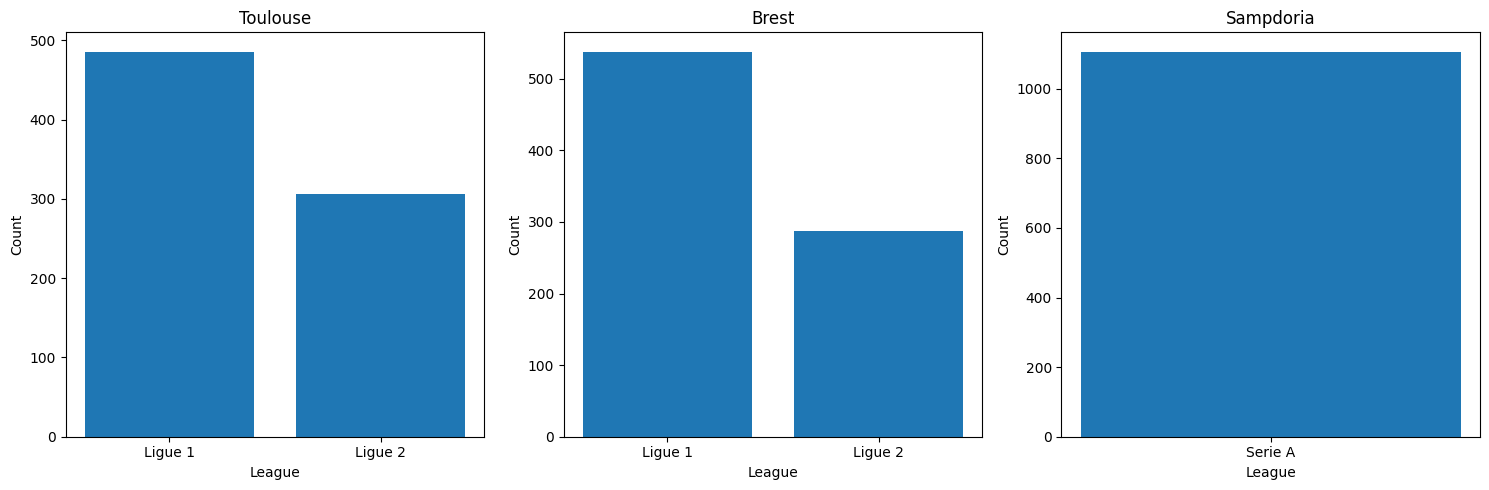

In [7]:
# Assuming train_home_player_statistics_df is already defined
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Added figsize for better visualization

for i, team in enumerate(train_home_player_statistics_df['TEAM_NAME'].unique()[:3]):
    # Filter dataframe for the current team
    team_df = train_home_player_statistics_df[train_home_player_statistics_df['TEAM_NAME'] == team]
    
    # Plot histogram for 'LEAGUE' column of the current team
    league_counts = team_df['LEAGUE'].value_counts()
    axs[i].bar(league_counts.index, league_counts.values)  
    axs[i].set_title(team)  
    axs[i].set_xlabel('League')  
    axs[i].set_ylabel('Count')  

plt.tight_layout() 
plt.show()


## On peut constater que les équipes appartiennent à plusieurs saisons différentes. On peut appercevori plusieurs ligues (divions) pour une seule équipe.

In [11]:
features_dict = {
    "offensive_features": [
        'TEAM_SHOTS_TOTAL',
        'TEAM_SHOTS_INSIDEBOX',
        'TEAM_SHOTS_OFF_TARGET',
        'TEAM_SHOTS_ON_TARGET',
        'TEAM_SHOTS_OUTSIDEBOX',
        'TEAM_PASSES',
        'TEAM_SUCCESSFUL_PASSES',
        'TEAM_CORNERS',
        'TEAM_ATTACKS',
        'TEAM_PENALTIES',
        'TEAM_DANGEROUS_ATTACKS',
        'TEAM_GOALS',
        'TEAM_SUCCESSFUL_PASSES_PERCENTAGE',
        'TEAM_BALL_POSSESSION',
    ],
    "defensive_features": [
        'TEAM_SAVES',
        'TEAM_BALL_SAFE',
        'TEAM_SUBSTITUTIONS',
    ],
    "disciplinary_features": [
        'TEAM_FOULS',
        'TEAM_YELLOWCARDS',
        'TEAM_REDCARDS',
        'TEAM_OFFSIDES',
    ],
    "general_game_results_features": [
        'TEAM_GAME_WON',
        'TEAM_GAME_DRAW',
        'TEAM_GAME_LOST',
        'TEAM_INJURIES',
    ],
}

# To access all features together as a single list, you can use a list comprehension
all_features = [feature for category in features_dict.values() for feature in category]

# Example of how to print all offensive features
print("Offensive Features:", features_dict["offensive_features"])


Offensive Features: ['TEAM_SHOTS_TOTAL', 'TEAM_SHOTS_INSIDEBOX', 'TEAM_SHOTS_OFF_TARGET', 'TEAM_SHOTS_ON_TARGET', 'TEAM_SHOTS_OUTSIDEBOX', 'TEAM_PASSES', 'TEAM_SUCCESSFUL_PASSES', 'TEAM_CORNERS', 'TEAM_ATTACKS', 'TEAM_PENALTIES', 'TEAM_DANGEROUS_ATTACKS', 'TEAM_GOALS', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE', 'TEAM_BALL_POSSESSION']


In [12]:
def aggregate_columns(df, base_names):
    column_groups = []
    for col in df.columns:
        for base_name in base_names:
            if base_name in col and col not in column_groups:
                column_groups.append(col)
    return column_groups


# Investigation 

In [13]:
def calculate_score(row):
    if (row[0] == 1) and (row[1] == 0):
        return 2  # win
    elif (row[0] == 0) and (row[1] == 1):
        return 1  # null
    elif (row[0] == 0) and (row[1] == 0):
        return 0  # lose
    
targ = train_scores.apply(lambda x: calculate_score(x), axis=1)


In [14]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

best_features = []

for key, list_variables in features_dict.items() :
    
    print(f"--------------------{key}--------------------------")
    cols = aggregate_columns(train_data, list_variables)
    mi_scores = mutual_info_classif(train_data.loc[:, cols], targ, discrete_features='auto')

    # Create a Series to view the scores alongside feature names for better readability
    mi_scores_series = pd.Series(mi_scores, index=cols)

    # Sort the series to see features with the highest mutual information first
    mi_scores_series = mi_scores_series.sort_values(ascending=False)
    print(mi_scores_series)
    selected_features = mi_scores_series[mi_scores_series > 0.018].index.tolist()

        # Add the selected features to the best_features list
    best_features.extend(selected_features)



--------------------offensive_features--------------------------
AWAY_TEAM_SUCCESSFUL_PASSES_season_average    0.028020
HOME_TEAM_GOALS_season_sum                    0.025087
HOME_TEAM_SHOTS_INSIDEBOX_season_average      0.024367
AWAY_TEAM_SHOTS_ON_TARGET_season_average      0.022119
HOME_TEAM_SHOTS_INSIDEBOX_season_sum          0.021918
                                                ...   
HOME_TEAM_PENALTIES_season_average            0.000000
HOME_TEAM_PENALTIES_5_last_match_sum          0.000000
AWAY_TEAM_PENALTIES_5_last_match_average      0.000000
AWAY_TEAM_SHOTS_ON_TARGET_5_last_match_std    0.000000
HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum         0.000000
Length: 160, dtype: float64
--------------------defensive_features--------------------------
HOME_TEAM_SAVES_season_sum                      0.012855
HOME_TEAM_SUBSTITUTIONS_season_average          0.011926
HOME_TEAM_SAVES_season_std                      0.010580
HOME_TEAM_SAVES_5_last_match_average            0.010160
AWAY_TEAM

In [12]:
len(best_features)

16

In [17]:
from sklearn.feature_selection import f_classif
import pandas as pd
import numpy as np

# Example usage of f_classif to perform ANOVA
f_values, p_values = f_classif(train_data, targ)

# Create a DataFrame to view F-values and P-values for each feature
anova_results = pd.DataFrame({
    'Feature': train_data.columns,
    'F-value': f_values,
    'P-value': p_values
})

# Sort the results by P-value to see the most significant features first
anova_results_sorted = anova_results.sort_values(by='P-value')

In [47]:
anova_results_sorted

,Feature,F-value,P-value
24,HOME_TEAM_SHOTS_INSIDEBOX_season_average,237.585372,5.769638e-102
20,HOME_TEAM_GAME_WON_season_sum,223.980159,2.858329e-96
45,HOME_TEAM_GAME_WON_season_average,222.741937,9.441029e-96
1,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,219.661070,1.847434e-94
26,HOME_TEAM_SHOTS_ON_TARGET_season_average,217.426753,1.598165e-93
...,...,...,...
60,HOME_TEAM_YELLOWCARDS_season_std,0.375451,6.869874e-01
250,AWAY_TEAM_SUBSTITUTIONS_5_last_match_average,0.346679,7.070389e-01
180,AWAY_TEAM_SUBSTITUTIONS_season_average,0.262412,7.691984e-01
205,AWAY_TEAM_SUBSTITUTIONS_season_std,0.046235,9.548176e-01


# Select Best Team Features

In [15]:
train_data_ = train_data.loc[:, best_features]
test_data_ = test_data.loc[:, best_features]

# Import Players Data

# Player Na fill

In [16]:
from sklearn.preprocessing import MinMaxScaler

excluded_columns = ["LEAGUE", "TEAM_NAME","POSITION"]
train_away_player = train_away_player_statistics_df.drop(excluded_columns, axis = 1)
train_home_player = train_home_player_statistics_df.drop(excluded_columns, axis = 1)
excluded_test_columns = ["POSITION"]
test_away_player = test_away_player_statistics_df.drop(excluded_test_columns, axis = 1)
test_home_player = test_home_player_statistics_df.drop(excluded_test_columns, axis = 1)

# Drop Columns with more than 50% of NaNs

In [17]:
col_to_drop_away = [column for column in train_away_player.columns if train_away_player[column].isna().sum()/ len(train_away_player) > 0.5]
train_away_player = train_away_player.drop(col_to_drop_away, axis = 1)
test_away_player = test_away_player.drop(col_to_drop_away, axis = 1)

col_to_drop_home =  [column for column in train_home_player.columns if train_home_player[column].isna().sum()/ len(train_home_player) > 0.5]
train_home_player = train_home_player.drop(col_to_drop_home, axis = 1)
test_home_player = test_home_player.drop(col_to_drop_home, axis = 1)

# Drop Rows with more than 50% of NaNs

In [233]:
# # Calculate the proportion of NaN values in each row
# nan_proportion = train_home_player.isna().sum(axis=1) / len(train_home_player.columns)

# # Identify rows where the proportion of NaN values is greater than 0.5
# rows_to_drop = nan_proportion[nan_proportion > 0.5].index

# # Drop these rows from the DataFrame
# train_home_player = train_home_player.drop(index=rows_to_drop)

In [234]:
# # Calculate the proportion of NaN values in each row
# nan_proportion = train_away_player.isna().sum(axis=1) / len(train_away_player.columns)

# # Identify rows where the proportion of NaN values is greater than 0.5
# rows_to_drop = nan_proportion[nan_proportion > 0.5].index

# # Drop these rows from the DataFrame
# train_away_player = train_away_player.drop(index=rows_to_drop)

In [18]:
import pandas as pd
import numpy as np


def fill_na_function_player_optimized(df):
    # Identifying columns with NaN values
    nan_cols = df.columns[df.isna().any()].tolist()
    
    # Calculate means for each group identified by 'ID', excluding 'PLAYER_NAME' from the mean calculation
    means = df.drop(["PLAYER_NAME"],axis=1).groupby('ID').transform(lambda x: x.fillna(x.mean()).fillna(0))

    # Fill NaN values in the original dataframe
    df[nan_cols] = df[nan_cols].fillna(means)

    # Recheck for any remaining NaNs
    recheck = df.columns[df.isna().any()].tolist()
    if not recheck:
        print("All NaNs cleaned!")
    else:
        print(f"There are {len(recheck)} columns not cleaned!")

    return df

In [19]:
train_home_player_ = fill_na_function_player_optimized(train_home_player)
train_away_player_ = fill_na_function_player_optimized(train_away_player)

All NaNs cleaned!
All NaNs cleaned!


In [92]:
train_home_player_.to_csv('/kaggle/working/train_home_player_.csv', index=True)
train_away_player_.to_csv('/kaggle/working/train_away_player_.csv', index=True)

In [20]:
test_home_player_ = test_home_player.fillna(0)
test_away_player_ = test_away_player.fillna(0)

# Construct team graph for each match 

In [21]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:0000:010:01


# Devide train & validation indexes

In [22]:
from torch.utils.data import random_split

total_size = len(train_data_)

# Define the ratio for splitting the dataset into training and validation
train_ratio = 0.8
# Calculate the sizes of each subset
train_size = int(train_ratio * total_size)
validate_size = total_size - train_size
# Generate indices: torch.arange() is similar to Python's range but returns a tensor
indices = np.arange(total_size)
# Split the indices into training and validation sets
train_indices, validate_indices = random_split(indices, [train_size, validate_size])


In [23]:
train_teams = train_data_.iloc[list(train_indices), :]
val_teams= train_data_.iloc[list(validate_indices), :]

train_home_player = train_home_player_.drop(["PLAYER_NAME"],axis=1)[train_home_player_.index.isin(list(train_indices))]
val_home_player = train_home_player_.drop(["PLAYER_NAME"],axis=1)[train_home_player_.index.isin(list(validate_indices))]

train_away_player = train_away_player_.drop(["PLAYER_NAME"],axis=1)[train_away_player_.index.isin(list(train_indices))]
val_away_player =  train_away_player_.drop(["PLAYER_NAME"],axis=1)[train_away_player_.index.isin(list(validate_indices))]

y_train = train_scores.iloc[list(train_indices), :]
y_val = train_scores.iloc[list(validate_indices), :]

# Scale the data

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize the StandardScaler
scaler_teams = MinMaxScaler()
scaler_home_player = MinMaxScaler()
scaler_away_player = MinMaxScaler()

# Fit on training data and transform both training and validation data
# For train_teams and val_teams
train_teams_scaled = scaler_teams.fit_transform(train_teams)
val_teams_scaled = scaler_teams.transform(val_teams)
test_teams_scaled = scaler_teams.transform(test_data_)

# For train_home_player and val_home_player
train_home_player_scaled = scaler_home_player.fit_transform(train_home_player)
val_home_player_scaled = scaler_home_player.transform(val_home_player)
test_home_player_scaled = scaler_home_player.transform(test_home_player_)

# For train_away_player and val_away_player
train_away_player_scaled = scaler_away_player.fit_transform(train_away_player)
val_away_player_scaled = scaler_away_player.transform(val_away_player)
test_away_player_scaled = scaler_away_player.transform(test_away_player_)

# Optionally, convert the scaled arrays back to DataFrames
# This step is useful if you need DataFrame functionalities later on
train_teams_scaled = pd.DataFrame(train_teams_scaled, index=train_teams.index, columns=train_teams.columns)
val_teams_scaled = pd.DataFrame(val_teams_scaled, index=val_teams.index, columns=val_teams.columns)
test_teams_scaled = pd.DataFrame(test_teams_scaled, index=test_data_.index, columns=test_data_.columns)

train_home_player_scaled = pd.DataFrame(train_home_player_scaled, index=train_home_player.index, columns=train_home_player.columns)
val_home_player_scaled = pd.DataFrame(val_home_player_scaled, index=val_home_player.index, columns=val_home_player.columns)
test_home_player_scaled = pd.DataFrame(test_home_player_scaled, index=test_home_player_.index, columns=test_home_player_.columns)

train_away_player_scaled = pd.DataFrame(train_away_player_scaled, index=train_away_player.index, columns=train_away_player.columns)
val_away_player_scaled = pd.DataFrame(val_away_player_scaled, index=val_away_player.index, columns=val_away_player.columns)
test_away_player_scaled = pd.DataFrame(test_away_player_scaled, index=test_away_player_.index, columns=test_away_player_.columns)

# Sort the indexes of the scaled DataFrames
train_teams_scaled = train_teams_scaled.sort_index()
val_teams_scaled = val_teams_scaled.sort_index()

train_home_player_scaled = train_home_player_scaled.sort_index()
val_home_player_scaled = val_home_player_scaled.sort_index()

train_away_player_scaled = train_away_player_scaled.sort_index()
val_away_player_scaled = val_away_player_scaled.sort_index()

y_train = y_train.sort_index()
y_val = y_val.sort_index()

## Save data

In [42]:
# Save the sorted and scaled DataFrames to CSV files
train_teams_scaled.to_csv('/kaggle/working/train_teams_scaled.csv', index=True)
val_teams_scaled.to_csv('/kaggle/working/val_teams_scaled.csv', index=True)
test_teams_scaled.to_csv('/kaggle/working/test_teams_scaled.csv', index=True)

train_home_player_scaled.to_csv('/kaggle/working/train_home_player_scaled.csv', index=True)
val_home_player_scaled.to_csv('/kaggle/working/val_home_player_scaled.csv', index=True)
test_home_player_scaled.to_csv('/kaggle/working/test_home_player_scaled.csv', index=True)

train_away_player_scaled.to_csv('/kaggle/working/train_away_player_scaled.csv', index=True)
val_away_player_scaled.to_csv('/kaggle/working/val_away_player_scaled.csv', index=True)
test_away_player_scaled.to_csv('/kaggle/working/test_away_player_scaled.csv', index=True)

# Save the sorted target variables to CSV files
y_train.to_csv('/kaggle/working/y_train.csv', index=True)
y_val.to_csv('/kaggle/working/y_val.csv', index=True)

## Load data

In [14]:
import pandas as pd

# Load the CSV files into DataFrames
train_teams_scaled = pd.read_csv('/kaggle/working/train_teams_scaled.csv', index_col=0)
val_teams_scaled = pd.read_csv('/kaggle/working/val_teams_scaled.csv', index_col=0)
test_teams_scaled = pd.read_csv('/kaggle/working/test_teams_scaled.csv', index_col=0)

train_home_player_scaled = pd.read_csv('/kaggle/working/train_home_player_scaled.csv', index_col=0)
val_home_player_scaled = pd.read_csv('/kaggle/working/val_home_player_scaled.csv', index_col=0)
test_home_player_scaled = pd.read_csv('/kaggle/working/test_home_player_scaled.csv', index_col=0)

train_away_player_scaled = pd.read_csv('/kaggle/working/train_away_player_scaled.csv', index_col=0)
val_away_player_scaled = pd.read_csv('/kaggle/working/val_away_player_scaled.csv', index_col=0)
test_away_player_scaled = pd.read_csv('/kaggle/working/test_away_player_scaled.csv', index_col=0)

y_train = pd.read_csv('/kaggle/working/y_train.csv', index_col=0)
y_val = pd.read_csv('/kaggle/working/y_val.csv', index_col=0)

#Load split indexes
train_indices, validate_indices = train_teams_scaled.index, val_teams_scaled.index


In [25]:
import torch
from torch_geometric.data import Data
from torch.utils.data import TensorDataset
from torch_geometric.data import DataLoader
from torch.utils.data import Dataset

def make_graph(df) :
        edge_index  = []
        x=[]
        weights = []
        matches = df.index.unique().sort_values()
        for match in matches :
            edges= []
            weights_match= []
            team_players = df.iloc[df.index == match, : ].reset_index()
            for i in range(len(team_players)) :
                for j in range(i+1, len(team_players)) :                         
                        min_played_together = min(team_players.loc[i, "PLAYER_MINUTES_PLAYED_5_last_match_sum"], team_players.loc[j, "PLAYER_MINUTES_PLAYED_5_last_match_sum"])
                        if min_played_together != 0 :
                            weights_match.append(min_played_together)
                            weights_match.append(min_played_together)
                            edges.append([i,j])
                            edges.append([j,i])
            
            # Convert edge indices and weights to  tensors and append to lists
            edge_index.append(torch.tensor(edges, dtype=torch.long).t().contiguous())
            weights.append(torch.tensor(weights_match, dtype=torch.float))
            feature_columns = [col for col in team_players.columns if col not in ['MATCH_ID', 'ID', 'LEAGUE', 'TEAM_NAME', 'POSITION', 'PLAYER_NAME']]
            x.append(torch.tensor(team_players[feature_columns].values, dtype=torch.float))  
    
        return x,edge_index, weights


# Form train and validation data 

In [26]:

class CombinedDataset(Dataset):
    def __init__(self, data_home, data_away, club_data_tensor, targets_tensor):
        self.data_home = data_home
        self.data_away = data_away
        self.club_data = club_data_tensor
        self.targets = targets_tensor

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        home_data = self.data_home[idx]
        away_data = self.data_away[idx]
        club_data = self.club_data[idx]
        target = self.targets[idx]
        return home_data, away_data, club_data, target

In [27]:
# Train Data

x_home, edges_home, weights_home = make_graph(train_home_player_scaled)
x_away, edges_away, weights_away = make_graph(train_away_player_scaled)

data_away = []
data_home =[]
club_data_list = []
targets_list = []

for i,match in enumerate(train_teams_scaled.index) :
   club_features = torch.tensor(train_teams_scaled.loc[match, :].values, dtype=torch.float)
   match_target = torch.tensor(y_train.loc[match, :].values, dtype=torch.float)
   data_home.append(Data(x=x_home[i], edge_index=edges_home[i], edge_attr = weights_home[i].unsqueeze(1)))
   data_away.append(Data(x=x_away[i], edge_index=edges_away[i], edge_attr = weights_away[i].unsqueeze(1)))
   club_data_list.append(club_features)
   targets_list.append(match_target)
    

club_data_tensor = torch.stack(club_data_list)
targets_tensor = torch.stack(targets_list)

dataset_train = CombinedDataset(data_home, data_away, club_data_tensor, targets_tensor)
train_loader = DataLoader(dataset_train, batch_size=128, shuffle=False)


In [28]:
# Validation Data
x_home, edges_home, weights_home = make_graph(val_home_player_scaled)
x_away, edges_away, weights_away = make_graph(val_away_player_scaled)

data_away = []
data_home =[]
club_data_list = []
targets_list = []

for i,match in enumerate(val_teams_scaled.index) :
   club_features = torch.tensor(val_teams_scaled.loc[match, :].values, dtype=torch.float)
   match_target = torch.tensor(y_val.loc[match, :].values, dtype=torch.float)
   data_home.append(Data(x=x_home[i], edge_index=edges_home[i], edge_attr = weights_home[i].unsqueeze(1)))
   data_away.append(Data(x=x_away[i], edge_index=edges_away[i], edge_attr = weights_away[i].unsqueeze(1)))
   club_data_list.append(club_features)
   targets_list.append(match_target)
    

club_data_tensor = torch.stack(club_data_list)
targets_tensor = torch.stack(targets_list)

val_dataset = CombinedDataset(data_home, data_away, club_data_tensor, targets_tensor)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [60]:
# Test Data
x_home, edges_home, weights_home = make_graph(test_home_player_scaled)
x_away, edges_away, weights_away = make_graph(test_away_player_scaled)

data_away = []
data_home =[]
club_data_list = []

for i,match in enumerate(test_teams_scaled.index) :
   club_features = torch.tensor(test_teams_scaled.loc[match, :].values, dtype=torch.float)
   data_home.append(Data(x=x_home[i], edge_index=edges_home[i], edge_attr = weights_home[i].unsqueeze(1)))
   data_away.append(Data(x=x_away[i], edge_index=edges_away[i], edge_attr = weights_away[i].unsqueeze(1)))
   club_data_list.append(club_features)
    

club_data_tensor = torch.stack(club_data_list)

test_dataset = CombinedDataset(data_home, data_away, club_data_tensor, torch.zeros(25368))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


# Model 

In [30]:
from torch import nn
from torch_geometric.nn import GCNConv, global_mean_pool

class Football_model(nn.Module):
    def __init__(self, num_node_features, nout, nhid, graph_hidden_channels, club_caracteristics_size, dropout=0.5):
        super(Football_model, self).__init__()
        
        self.drop = nn.Dropout(p=dropout)

        self.ln1 = nn.LayerNorm((nout))
                
        # For GCN:
        self.conv1 = GCNConv(num_node_features, graph_hidden_channels)
        self.conv2 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        
        self.conv3 = GCNConv(num_node_features, graph_hidden_channels)
        self.conv4 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        
        # Linear layers for the concatenated features
        self.hidden1 = nn.Linear(graph_hidden_channels * 2 + club_caracteristics_size, nhid)
        self.hidden2 = nn.Linear(nhid, nhid)
        self.hidden3 = nn.Linear(nhid, nout)

    def forward(self, home_batch, away_batch, club_batch):
        # Home team convolution
        x_home = self.conv1(home_batch.x, home_batch.edge_index, home_batch.edge_attr)
        x_home = x_home.relu()
        x_home = self.conv2(x_home, home_batch.edge_index, home_batch.edge_attr)
        x_home = x_home.relu()
        readout_home = global_mean_pool(x_home, home_batch.batch)  # [batch_size, graph_hidden_channels]
        
        # Away team convolution
        x_away = self.conv3(away_batch.x, away_batch.edge_index, away_batch.edge_attr)
        x_away = x_away.relu()
        x_away = self.conv4(x_away, away_batch.edge_index, away_batch.edge_attr)
        x_away = x_away.relu()
        readout_away = global_mean_pool(x_away, away_batch.batch)  # [batch_size, graph_hidden_channels]
        
        # Club characteristics
        club = club_batch

        # Concatenation of home and away readouts (graph level representations) along with club characteristics
        concatenated_team = torch.cat([readout_home, readout_away, club], dim=1)  # [batch_size, graph_hidden_channels * 2 + club_caracteristics_size]
        
        # Pass through the fully connected layers
        z = self.hidden1(concatenated_team).relu()
        z = self.hidden2(z).relu()
        z = self.hidden3(z)
  
        return z


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
model1 = Football_model(num_node_features = 272,nout = 3, nhid=256,graph_hidden_channels=600, club_caracteristics_size = 19) 
model1.to(device)

Football_model(
  (drop): Dropout(p=0.5, inplace=False)
  (ln1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
  (conv1): GCNConv(272, 600)
  (conv2): GCNConv(600, 600)
  (conv3): GCNConv(272, 600)
  (conv4): GCNConv(600, 600)
  (hidden1): Linear(in_features=1219, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=256, bias=True)
  (hidden3): Linear(in_features=256, out_features=3, bias=True)
)

In [37]:
import torch.optim as optim

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.SGD(model1.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

In [39]:
nb_epochs = 50  # N of epochs

for epoch in range(nb_epochs):
    print(f'-----EPOCH {epoch+1}-----')
    
    # Training phase
    model1.train()
    total_loss = 0
    for data_home, data_away, club_data_tensor, targets_tensor in train_loader:
        logits = model1(data_home.to(device), 
                       data_away.to(device), 
                       club_data_tensor.to(device))
        
        current_loss = loss_fn(logits, targets_tensor.to(device))
        
        optimizer.zero_grad()
        current_loss.backward()
        optimizer.step()
        
        total_loss += current_loss.item()

    print(f'Training Loss: {total_loss / len(train_loader)}')
    
    # Validation phase
    model1.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for data_home, data_away, club_data_tensor, targets_tensor in val_loader:
            logits = model1(data_home.to(device), 
                           data_away.to(device), 
                           club_data_tensor.to(device))
            val_loss = loss_fn(logits, targets_tensor.to(device))
            total_val_loss += val_loss.item()

            # Calculate accuracy
            predicted_labels = torch.argmax(logits.detach().cpu(), 1)
            targets_tensor = torch.argmax(targets_tensor, 1)
            correct_predictions += (predicted_labels == targets_tensor).sum().item()
            total_predictions += targets_tensor.size(0)

    validation_accuracy = correct_predictions / total_predictions
    print(f'Validation Loss: {total_val_loss / len(val_loader)}')
    print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')


-----EPOCH 1-----
Training Loss: 1.0791708602533712
Validation Loss: 1.0636227488517762
Validation Accuracy: 44.90%
-----EPOCH 2-----
Training Loss: 1.0656804527555193
Validation Loss: 1.0502327263355256
Validation Accuracy: 44.94%
-----EPOCH 3-----
Training Loss: 1.0465175447525916
Validation Loss: 1.0232951819896698
Validation Accuracy: 49.94%
-----EPOCH 4-----
Training Loss: 1.025690865207028
Validation Loss: 1.0095889806747436
Validation Accuracy: 49.61%
-----EPOCH 5-----
Training Loss: 1.0210422068447262
Validation Loss: 1.007804548740387
Validation Accuracy: 49.74%
-----EPOCH 6-----
Training Loss: 1.0201093732536612
Validation Loss: 1.0071441888809205
Validation Accuracy: 49.98%
-----EPOCH 7-----
Training Loss: 1.019415366185176
Validation Loss: 1.0066910922527312
Validation Accuracy: 50.26%
-----EPOCH 8-----
Training Loss: 1.0188571888130982
Validation Loss: 1.0062907069921494
Validation Accuracy: 50.59%
-----EPOCH 9-----
Training Loss: 1.0183296706769374
Validation Loss: 1.0059

In [43]:
torch.save(model1, '/kaggle/working/model1_conv.pth')

# Submission 

In [61]:
model1.eval()  

predictions = []  

with torch.no_grad():  
    for data_home, data_away, club_data_tensor, _ in test_loader:
        # Generate predictions
        test_logits = model1(data_home.to(device), 
                             data_away.to(device), 
                             club_data_tensor.to(device))
        
        predictions.append(test_logits.cpu())

# Concatenate all predictions across batches
all_predictions = torch.cat(predictions, dim=0)
_, indices = torch.max(all_predictions, 1)

# Convert these indices into one-hot encoded format
one_hot = torch.nn.functional.one_hot(indices, num_classes=tensor.shape[1])

predictions_numpy = one_hot.numpy()
predictions_df = pd.DataFrame(predictions_numpy, columns=['HOME_WINS', 'DRAW', 'AWAY_WINS'])
predictions_df.index = test_data.index
submission = predictions_df.reset_index()
submission.to_csv('/kaggle/working/submission1.csv', index=False)

# GAT Model

In [77]:
from torch import nn
import torch
from torch_geometric.nn import GATConv, global_mean_pool

class Football_GAT_model(nn.Module):
    def __init__(self, num_node_features, nout, nhid, graph_hidden_channels, club_caracteristics_size, dropout=0.3):
        super(Football_GAT_model, self).__init__()
        
        self.drop = nn.Dropout(p=dropout)

        self.conv1_home = GATConv(num_node_features, graph_hidden_channels, heads=4, concat=True)
        self.conv3_home = GATConv(graph_hidden_channels*4, graph_hidden_channels, heads=6, concat=False)  # Outputs are averaged
        
        self.conv1_away = GATConv(num_node_features, graph_hidden_channels, heads=4, concat=True)
        self.conv3_away = GATConv(graph_hidden_channels*4, graph_hidden_channels, heads=6, concat=False)  # Outputs are averaged
        
        # Linear layers for the concatenated features
        self.hidden1 = nn.Linear(graph_hidden_channels * 2 + club_caracteristics_size, nhid)
        self.hidden2 = nn.Linear(nhid, nout)
        
        self.elu = nn.ELU()

    def forward(self, home_batch, away_batch, club_batch):
        # Home team convolution
        
        x_home = self.conv1_home(home_batch.x, home_batch.edge_index).relu()
        x_home = self.conv3_home(x_home, home_batch.edge_index).relu()

        readout_home = global_mean_pool(x_home, home_batch.batch)  # [batch_size, graph_hidden_channels]
        
        # Away team convolution
        x_away = self.conv1_away(away_batch.x, away_batch.edge_index).relu()
        x_away = self.conv3_away(x_away, away_batch.edge_index).relu()
        readout_away = global_mean_pool(x_away, away_batch.batch)  # [batch_size, graph_hidden_channels]
        
        # Club characteristics
        club = club_batch

        # Concatenation of home and away readouts (graph level representations) along with club characteristics
        concatenated_team = torch.cat([readout_home, readout_away, club], dim=1)  # [batch_size, graph_hidden_channels * 2 + club_caracteristics_size]
        
        # Pass through the fully connected layers
        z = self.hidden1(concatenated_team).relu()
        z = self.hidden2(z)
  
        return z


In [78]:
model = Football_GAT_model(num_node_features = 272,nout = 3, nhid=256,graph_hidden_channels=256, club_caracteristics_size = 19) 
model.to(device)

Football_GAT_model(
  (drop): Dropout(p=0.3, inplace=False)
  (conv1_home): GATConv(272, 256, heads=4)
  (conv3_home): GATConv(1024, 256, heads=6)
  (conv1_away): GATConv(272, 256, heads=4)
  (conv3_away): GATConv(1024, 256, heads=6)
  (hidden1): Linear(in_features=531, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=3, bias=True)
  (elu): ELU(alpha=1.0)
)

In [79]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.SGD(model1.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

In [80]:
nb_epochs = 50  # N of epochs

for epoch in range(nb_epochs):
    print(f'-----EPOCH {epoch+1}-----')
    
    # Training phase
    model.train()
    total_loss = 0
    for data_home, data_away, club_data_tensor, targets_tensor in train_loader:
        logits = model(data_home.to(device), 
                       data_away.to(device), 
                       club_data_tensor.to(device))
        
        current_loss = loss_fn(logits, targets_tensor.to(device))
        
        optimizer.zero_grad()
        current_loss.backward()
        optimizer.step()
        
        total_loss += current_loss.item()

    print(f'Training Loss: {total_loss / len(train_loader)}')
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for data_home, data_away, club_data_tensor, targets_tensor in val_loader:
            logits = model(data_home.to(device), 
                           data_away.to(device), 
                           club_data_tensor.to(device))
            val_loss = loss_fn(logits, targets_tensor.to(device))
            total_val_loss += val_loss.item()

            # Calculate accuracy
            predicted_labels = torch.argmax(logits.detach().cpu(), 1)
            targets_tensor = torch.argmax(targets_tensor, 1)
            correct_predictions += (predicted_labels == targets_tensor).sum().item()
            total_predictions += targets_tensor.size(0)

    validation_accuracy = correct_predictions / total_predictions
    print(f'Validation Loss: {total_val_loss / len(val_loader)}')
    print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')


-----EPOCH 1-----
Training Loss: 1.1015713214874268
Validation Loss: 1.1017747879028321
Validation Accuracy: 25.36%
-----EPOCH 2-----
Training Loss: 1.1015713214874268
Validation Loss: 1.1017747819423676
Validation Accuracy: 25.36%
-----EPOCH 3-----
Training Loss: 1.1015713230355995
Validation Loss: 1.1017747879028321
Validation Accuracy: 25.36%
-----EPOCH 4-----
Training Loss: 1.101571324583772
Validation Loss: 1.1017747879028321
Validation Accuracy: 25.36%
-----EPOCH 5-----
Training Loss: 1.1015713230355995
Validation Loss: 1.1017747819423676
Validation Accuracy: 25.36%
-----EPOCH 6-----
Training Loss: 1.1015713214874268
Validation Loss: 1.1017747879028321
Validation Accuracy: 25.36%
-----EPOCH 7-----
Training Loss: 1.1015713214874268
Validation Loss: 1.1017747879028321
Validation Accuracy: 25.36%
-----EPOCH 8-----
Training Loss: 1.1015713183910816
Validation Loss: 1.1017747879028321
Validation Accuracy: 25.36%
-----EPOCH 9-----
Training Loss: 1.101571319939254
Validation Loss: 1.101